# Blood Smear Classification

We'll compare the performance of a dense neural network and of a convolutional neural network with a dense top for the classification of blood smears in a dataset of blood smears containing blood cells with and without malaria. 

## Load Malaria Dataset

We load and uncompress the malaria dataset available at https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip.

This dataset was origianlly published in S. Rajaraman, S. K. Antani, M. Poost- chi, K. Silamut, Md A. Hossain, R. J. Maude, S. Jaeger, and G. R. Thoma. _Pre-trained convolutional neural networks as feature extractors toward improved malaria parasite detection in thin blood smear images._ PeerJ 6, e4568, 2018.

In [1]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

dataset_path = os.path.join(".", "blood_smears_dataset")
if not os.path.exists(dataset_path):
    url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
    download_url(url, ".")
    _extract_zip("cell_images.zip", dataset_path, None)
    os.remove("cell_images.zip")

We now obtain the paths to the files containing the `Infected` and `Parasitized` images.

In [2]:
import glob

base_dir = os.path.join(dataset_path, "cell_images")
uninfected_files = glob.glob(os.path.join(base_dir, "Uninfected", "*.png"))
parasitized_files = glob.glob(os.path.join(base_dir, "Parasitized", "*.png"))


## Visualize Data

We impleemnt the function `plot_blood_smears`, save it in `fnc_blood_smears.py` ...

```python
def plot_blood_smears(title, files):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(3, 3, figsize=(8, 8))
    for i, ax in enumerate(axs.ravel()):
        image = plt.imread(files[i])
        ax.imshow(image)
        
    fig.suptitle(title, fontsize=16)
    plt.show()
```

... and use it to visualize some of the data.

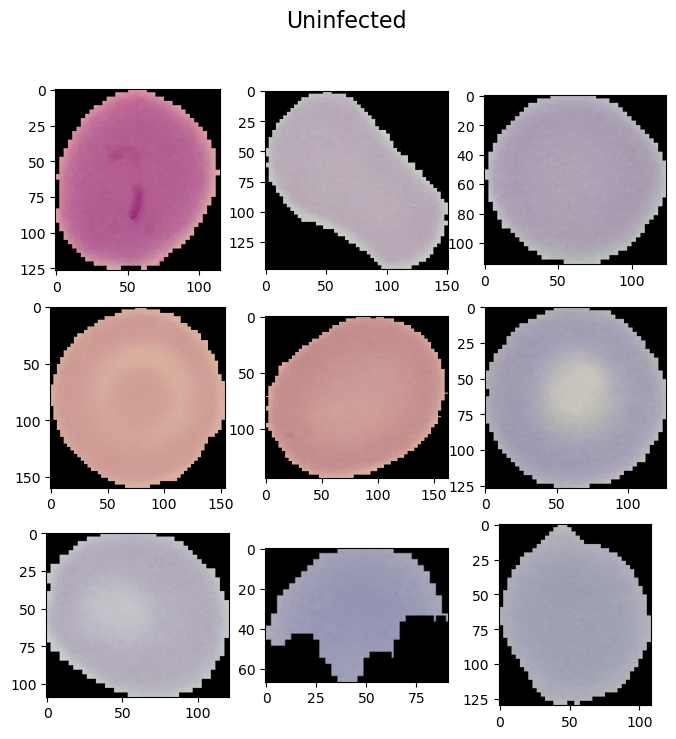

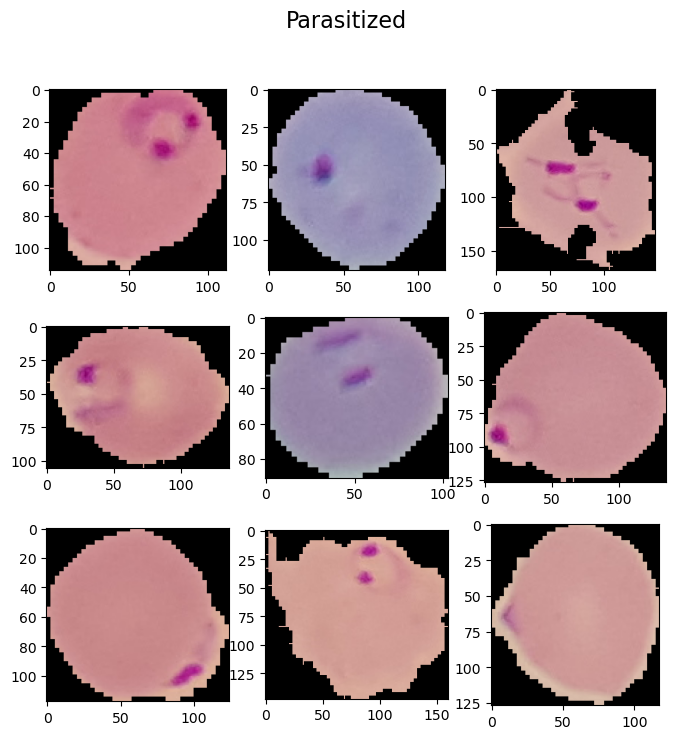

In [3]:
from fnc_blood_smears import plot_blood_smears

plot_blood_smears("Uninfected", uninfected_files)
plot_blood_smears("Parasitized", parasitized_files)

## Preprocess Data

We define a transformation to resize the images to 28 by 28 pixels and convert them to PyTorch tensors (note that `ToTensor()` also normalizes their values between 0 and 1).

In [4]:
from torchvision.transforms import Compose, Resize, ToTensor

input_transform = Compose([Resize((28, 28)), ToTensor()])

We then define a transformation to make the target equal to 0 for the uninfected cells and to 1 for the parasitized ones, achieved through `abs(1 - target)`. This step is followed by converting it into a PyTorch tensor using `tensor()`, ensuring the data is in the correct format for PyTorch operations. Next, we convert the tensor into a floating-point type with `float()`, enhancing its compatibility with PyTorch's computational requirements. Finally, we add a new dimension to the tensor using `unsqueeze(-1)`, preparing it for batch processing in neural network models.

In [5]:
from torch import tensor

def target_transform(target):
    return tensor(abs(1 - target)).float().unsqueeze(-1)

We then set up a dataset where images are loaded from a structured directory (`base_dir`).

In [6]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(base_dir, 
                      transform=input_transform, 
                      target_transform=target_transform)

We extract a subset with 5,000 of the ca. 27,000 cell images for computational efficiency, and split it into `train` and `test` sets.

In [7]:
from torch import randperm
from torch.utils.data import random_split, Subset

images_num = 5000
images_idx = randperm(len(dataset))[:images_num]
subset = Subset(dataset, images_idx)

train_size = int(0.8 * len(subset))
test_size = len(subset) - train_size
train, test = random_split(subset, [train_size, test_size])

Finally, we define the dataloaders for both sets. For the training, we'll set `batch_size=32`, while we'll set a larger batch for the testing.

In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=124, shuffle=False)

## Dense Neural Network

We define a dense neural network (DNN) using `deeplay` with 2 layers with 128 neurons.

In [9]:
import deeplay as dl
from torch.nn import Sigmoid

dnn = dl.MultiLayerPerceptron(in_features=28 * 28 * 3,
                               hidden_features=[128, 128],
                               out_features=1,
                               out_activation=Sigmoid)

print(dnn)

MultiLayerPerceptron(
  (blocks): LayerList(
    (0): LayerActivationNormalization(
      (layer): Layer[Linear](in_features=2352, out_features=128)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=128)
    )
    (1): LayerActivationNormalization(
      (layer): Layer[Linear](in_features=128, out_features=128)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=128)
    )
    (2): LayerActivationNormalization(
      (layer): Layer[Linear](in_features=128, out_features=1)
      (activation): Layer[Sigmoid]()
      (normalization): Layer[Identity](num_features=1)
    )
  )
)


We then define a classifier using the DNN ...

In [10]:
import torchmetrics as tm

dnn_classifier_template = dl.BinaryClassifier(model=dnn,
                                              optimizer=dl.RMSprop(lr=.001))

dnn_classifier = dnn_classifier_template.create()

print(dnn_classifier)

BinaryClassifier(
  (loss): BCELoss()
  (train_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=test
  )
  (model): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LayerActivationNormalization(
        (layer): Linear(in_features=2352, out_features=128, bias=True)
        (activation): ReLU()
        (normalization): Identity()
      )
      (1): LayerActivationNormalization(
        (layer): Linear(in_features=128, out_features=128, bias=True)
        (activation): ReLU()
        (normalization): Identity()
      )
      (2): LayerActivationNormalization(
        (layer): Linear(in_features=128, out_features=1, bias=True)
        (activation): Sigmoid()
        (normalization): Identity()
      )
    )
  )
  (optimizer): RMSprop[RMSprop](lr=0.001, params=<ge

... and a trainer.

In [11]:
dnn_trainer = dl.Trainer(max_epochs=20, accelerator="auto")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Train

We train the DNN classifier ...

In [12]:
dnn_trainer.fit(dnn_classifier, train_loader)

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type                 | Params
-------------------------------------------------------
0 | loss          | BCELoss              | 0     
1 | train_metrics | MetricCollection     | 0     
2 | val_metrics   | MetricCollection     | 0     
3 | test_metrics  | MetricCollection     | 0     
4 | model         | MultiLayerPerceptron | 317 K 
5 | optimizer     | RMSprop              | 0     
-------------------------------------------------------
317 K     Trainable params
0         Non-trainable params
317 K     Total params
1.271     Total estimated model params size (MB)
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a 

Epoch 19: 100%|██████████| 125/125 [00:04<00:00, 30.13it/s, v_num=29, train_loss_step=0.597, trainBinaryAccuracy_step=0.688, train_loss_epoch=0.568, trainBinaryAccuracy_epoch=0.696]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 125/125 [00:04<00:00, 30.08it/s, v_num=29, train_loss_step=0.597, trainBinaryAccuracy_step=0.688, train_loss_epoch=0.568, trainBinaryAccuracy_epoch=0.696]


... and evaluate its performance over the training set.

In [13]:
_ = dnn_trainer.test(dnn_classifier, test_loader)

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 9/9 [00:01<00:00,  6.01it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
testBinaryAccuracy_epoch    0.6729999780654907
     test_loss_epoch        0.6118878126144409
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Plot ROC Curve

We implement the `plot_roc`, save it in `fnc_blood_smears.py` ...

```python
def plot_roc(classifier, dataset):
    from torch import tensor, stack
    from sklearn.metrics import roc_curve, auc
    from matplotlib import pyplot as plt

    # calculate predictions
    images, gt = zip(*dataset)
    pred = classifier(tensor(stack(images))).tolist()
    
    # calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(gt, pred, pos_label=1) 
    roc = auc(fpr, tpr) 

    # plot the ROC curve
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc:.3f})", linewidth=2)
    plt.title("ROC curve")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.axis("square")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend(loc = 'center right')
    plt.show()

    return images, gt, pred, roc
```

... and use it to visualize the receiver operator curve (ROC). Furthermore, this function returns the test images, the groundtruths, the predictions, and the ROC.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/Ch03_CNN/Ex03B/fnc_blood_smears.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = classifier(tensor(stack(images))).tolist()


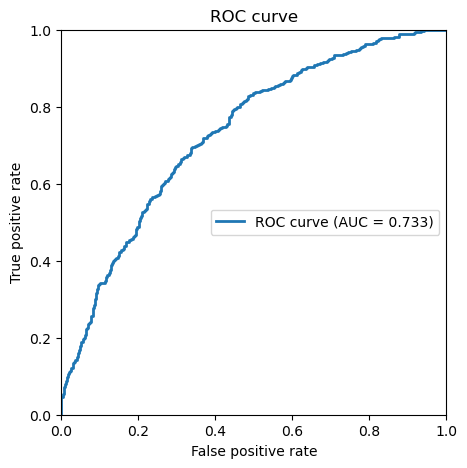

In [14]:
from fnc_blood_smears import plot_roc

_ = plot_roc(classifier=dnn_classifier, dataset=test)

## Convolutional Neural Network with a Dense Top

We now build a convolutional neural network (CNN) with a dense top using `deeplay`.


In [15]:
from torch.nn import AdaptiveAvgPool2d, MaxPool2d

cnn = dl.Sequential(
    dl.ConvolutionalNeuralNetwork(
        in_channels=3, 
        hidden_channels=[32, 32, 64], 
        out_channels=64,
    ),
    dl.Layer(AdaptiveAvgPool2d, output_size=1),
    dl.MultiLayerPerceptron(
        in_features=64, 
        hidden_features=[], 
        out_features=1,
        out_activation=Sigmoid,
    )
)
cnn[0].blocks[2].pool.configure(MaxPool2d, kernel_size=2)

print(cnn)

Sequential(
  (0): ConvolutionalNeuralNetwork(
    (blocks): LayerList(
      (0): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (1): PoolLayerActivationNormalization(
        (pool): Layer[Identity]()
        (layer): Layer[Conv2d](in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (2): PoolLayerActivationNormalization(
        (pool): Layer[MaxPool2d](kernel_size=2)
        (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        (activation): Layer[ReLU]()
        (normalization): Layer[Identity](num_features=64)
      )
      (3): PoolLayerActivationNormalization(
        (pool): Layer[Ident

We then define a classifier using the CNN ...

In [16]:
cnn_classifier_template = dl.BinaryClassifier(
    model=cnn, 
    optimizer=dl.RMSprop(lr=.001),
)

cnn_classifier = cnn_classifier_template.create()

print(cnn_classifier)

BinaryClassifier(
  (loss): BCELoss()
  (train_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (BinaryAccuracy): BinaryAccuracy(),
    prefix=test
  )
  (model): Sequential(
    (0): ConvolutionalNeuralNetwork(
      (blocks): LayerList(
        (0): PoolLayerActivationNormalization(
          (pool): Identity()
          (layer): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (normalization): Identity()
        )
        (1): PoolLayerActivationNormalization(
          (pool): Identity()
          (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): ReLU()
          (normalization): Identity()
        )
        (2): PoolLayerActivationNormalization(
          (pool): MaxPool2d(kernel_size=2, stride=2, padding=

...  and a trainer.

In [17]:
cnn_trainer = dl.Trainer(max_epochs=20, accelerator="auto")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Train

We then train the CNN classifier

In [18]:
cnn_trainer.fit(cnn_classifier, train_loader)

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | BCELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential       | 65.6 K
5 | optimizer     | RMSprop          | 0     
---------------------------------------------------
65.6 K    Trainable params
0         Non-trainable params
65.6 K    Total params
0.263     Total estimated model params size (MB)
/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the 

Epoch 19: 100%|██████████| 125/125 [00:07<00:00, 15.79it/s, v_num=30, train_loss_step=0.168, trainBinaryAccuracy_step=0.938, train_loss_epoch=0.166, trainBinaryAccuracy_epoch=0.952] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 125/125 [00:07<00:00, 15.77it/s, v_num=30, train_loss_step=0.168, trainBinaryAccuracy_step=0.938, train_loss_epoch=0.166, trainBinaryAccuracy_epoch=0.952]


... and evaluate its performance over the test set.

In [19]:
_ = cnn_trainer.test(cnn_classifier, test_loader)

/Users/giovannivolpe/miniconda3/envs/py310/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 9/9 [00:01<00:00,  7.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
testBinaryAccuracy_epoch    0.9279999732971191
     test_loss_epoch        0.28933337330818176
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Plot ROC Curve

We finally display the ROC curve with the AUC value.

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/Ch03_CNN/Ex03B/fnc_blood_smears.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = classifier(tensor(stack(images))).tolist()


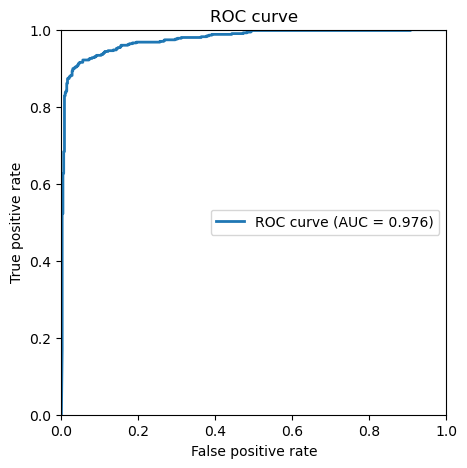

In [20]:
images, gt, pred, _ = plot_roc(classifier=cnn_classifier, dataset=test)

## Failure analysis

We now write the `plot_failures` function, save it in `fnc_blood_smears.py` ...

```python
def plot_failures(images, gt, pred, threshold=.5, plot_num=5):
    from matplotlib import pyplot as plt 
    from numpy import array, squeeze
    
    pred = array(pred).squeeze()
    gt = array(gt).squeeze()
    images = array(images)

    false_positives = (pred > threshold) & (gt == 0)
    false_positives_images = images[false_positives]

    false_negatives = (pred < threshold) & (gt == 1)
    false_negatives_images = images[false_negatives]

    plt.figure(figsize=(plot_num * 2, 5))
    for i in range(plot_num):
        # false positives
        plt.subplot(2, plot_num, i + 1)
        plt.imshow(false_positives_images[i].transpose(1, 2, 0))
        if i == 0:
            plt.title("False positives", fontsize=16, y=1.1)

        # false negatives
        plt.subplot(2, plot_num, plot_num + i + 1)
        plt.imshow(false_negatives_images[i].transpose(1, 2, 0))
        if i == 0:
            plt.title("False negatives", fontsize=16, y=1.1)

    plt.tight_layout()
    plt.show()
```

... and visualize some of the wrongly classified cells, looking for common patterns.

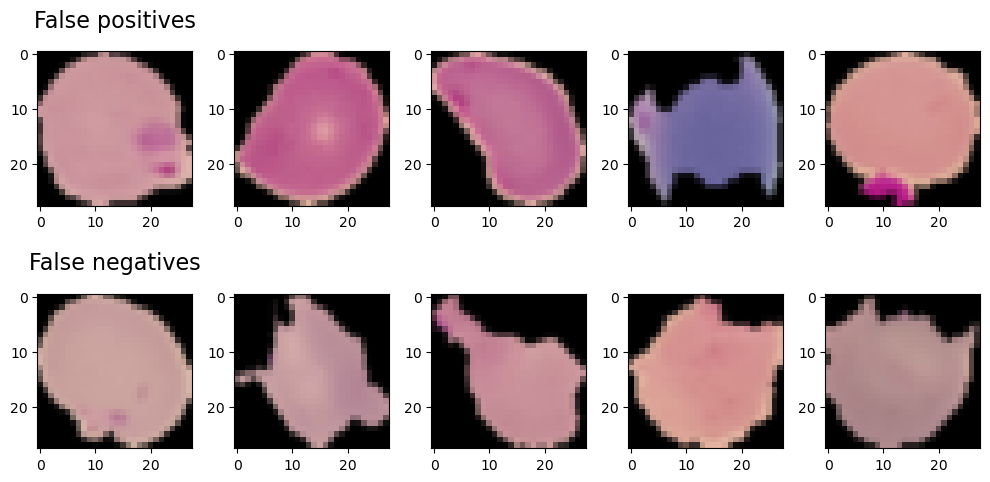

In [21]:
from fnc_blood_smears import plot_failures

plot_failures(images, gt, pred)

## Access Filters

We can access value of the filters used by the neural network. The follwoing code accesses the 32nd filter's weights in the first convolutional layer of the CNN. It navigates through the model's first module (`model[0]`), selects the initial block (`blocks[0]`), and then targets the layer's weights (`layer.weight[31]`). 

In [22]:
filter = cnn_classifier.model[0].blocks[0].layer.weight[31]

print(filter)

tensor([[[-0.1551,  0.1371,  0.1534],
         [ 0.1538, -0.1402,  0.1347],
         [-0.0456,  0.1654,  0.1800]],

        [[-0.1514,  0.1844, -0.0081],
         [ 0.0685,  0.1699, -0.0107],
         [-0.0204, -0.1747,  0.1158]],

        [[-0.2012, -0.1667, -0.1397],
         [ 0.1090, -0.0513, -0.1471],
         [ 0.0304, -0.2022, -0.1598]]], grad_fn=<SelectBackward0>)


## Activations and Grad-CAM

We randomly pick the image of an infected smear to then check the activations it produces on the last convolutional layer.

In [23]:
import numpy as np
from torch import cat

gt_as_list = (cat(gt) == 1).tolist() # Convert the ground truth labels to a categorical format and then to a list.
indices = np.where(gt_as_list)[0] # Find the indices where the ground truth labels are equal to 1.
index = np.random.choice(indices, 1)[0] # Randomly select one index from those indices.
image = images[index] # Retrieve the image corresponding to the selected index.

To visualize the network features, we can use `hooks`. These are functionalities that allows us to access the information that the model sees during forward and backward passes, such as activations and gradients. 

We define them as context manager classes, so that we can use them with the `with` statement. This ensures that the hooks are properly set up and removed when they are no longer needed, preventing potential side effects or memory leaks. This is particularly important in complex neural network models where maintaining computational efficiency and correctness is crucial.

Activations at a specific layer can be obtained from the forward pass using the `fwd_hook` class:

* The `__init__(self, layer)` method registers a forward hook to the provided layer. The hook is set to the `hook_func()` method. This hook will be called every time the forward method of the layer is executed.

* The `hook_func(self, layer, i, o)` method is called during the forward pass of the model: `layer` is the layer to which the hook is attached; `input` is the input to the model's layer; and `o` is the output from the model's layer. The output `o` is detached from the current computation graph and cloned to prevent any modifications to `o` from affecting the original tensor, and avoids potential issues with backpropagation. Note: `o[0]` is used because `o` is a tuple of activations, one for each image.

* The `__enter__(self, *args)` method returns this object when entering the context (using the `with` statement).

* The `__exit__(self, *args)` method removes the forward hook from the model when exiting the context. This is important for resource management and to ensure that the hook does not remain active beyond its intended scope.

```python
class fwd_hook():
    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_func)

    def hook_func(self, layer, i, o):
        print("Forward hook running ...") 
        self.activations = o.detach().clone()
        print(f"Activations size: {self.activations.size()}")

    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()
```

Gradients at a specific layer can be obtained from the backward pass using the `bwd_hook` class:

* The `__init__(self, layer)` method registers a full backward hook to the provided layer. The hook is set to the `hook_func` method. This hook will be called every time the backward pass of the layer is executed.

* The `hook_func(self, layer, gi, go)` function is called during the backward pass of the model: `layer` is the layer to which the hook is attached; `gi` represents the gradients with respect to the input; and `go` represents the gradients with respect to the output. The first output gradient `go[0]` is detached from the current computation graph and cloned. This prevents any modifications to `go[0]` from affecting the original tensor, and avoids potential issues with backpropagation. Note: `go[0]` is used because `go` is a tuple of gradients, one for each output (even though in this case we only have one input).

* The `__enter__(self, *args)` method returns this object when entering the context (using the `with` statement).

* The `__exit__(self, *args)` method removes the backward hook from the model when exiting the context. This is important to ensure that the hook is only active during the intended scope and to release any resources associated with the hook.

```python
class bwd_hook():
    def __init__(self, layer):
        self.hook = layer.register_full_backward_hook(self.hook_func)

    def hook_func(self, layer, gi, go):
        print("Backward hook running ...")
        self.gradients = go[0].detach().clone()
        print(f"Gradients size: {self.gradients.size()}")

    def __enter__(self, *args): 
        return self
    
    def __exit__(self, *args): 
        self.hook.remove()
```

We add both classes to `fnc_blood_smears.py`.

In [24]:
from fnc_blood_smears import fwd_hook, bwd_hook

layer = cnn_classifier.model[0].blocks[3].layer

with bwd_hook(layer) as bh, fwd_hook(layer) as fh:
    pred = cnn_classifier.model(image.unsqueeze(0)) # Forward pass through the model with the given image
    pred.backward() # Executing the backward pass for backpropagation

Forward hook running ...
Activations size: torch.Size([1, 64, 14, 14])
Backward hook running ...
Gradients size: torch.Size([1, 64, 14, 14])


We can now plot the activations in the last convolutional layer using the `plot_activations()` function ...

```python
def plot_activations(activations, cols=8):
    from matplotlib import pyplot as plt

    rows = -(activations.shape[0] // -cols)

    fig, axs = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    for i, ax in enumerate(axs.ravel()):
        ax.axis('off')
        if i < activations.shape[0]:
            ax.imshow(activations[i].numpy())
            ax.set_title(i)

    fig.tight_layout()
    plt.show()
```

... which is added to `fnc_blood_smears.py`.

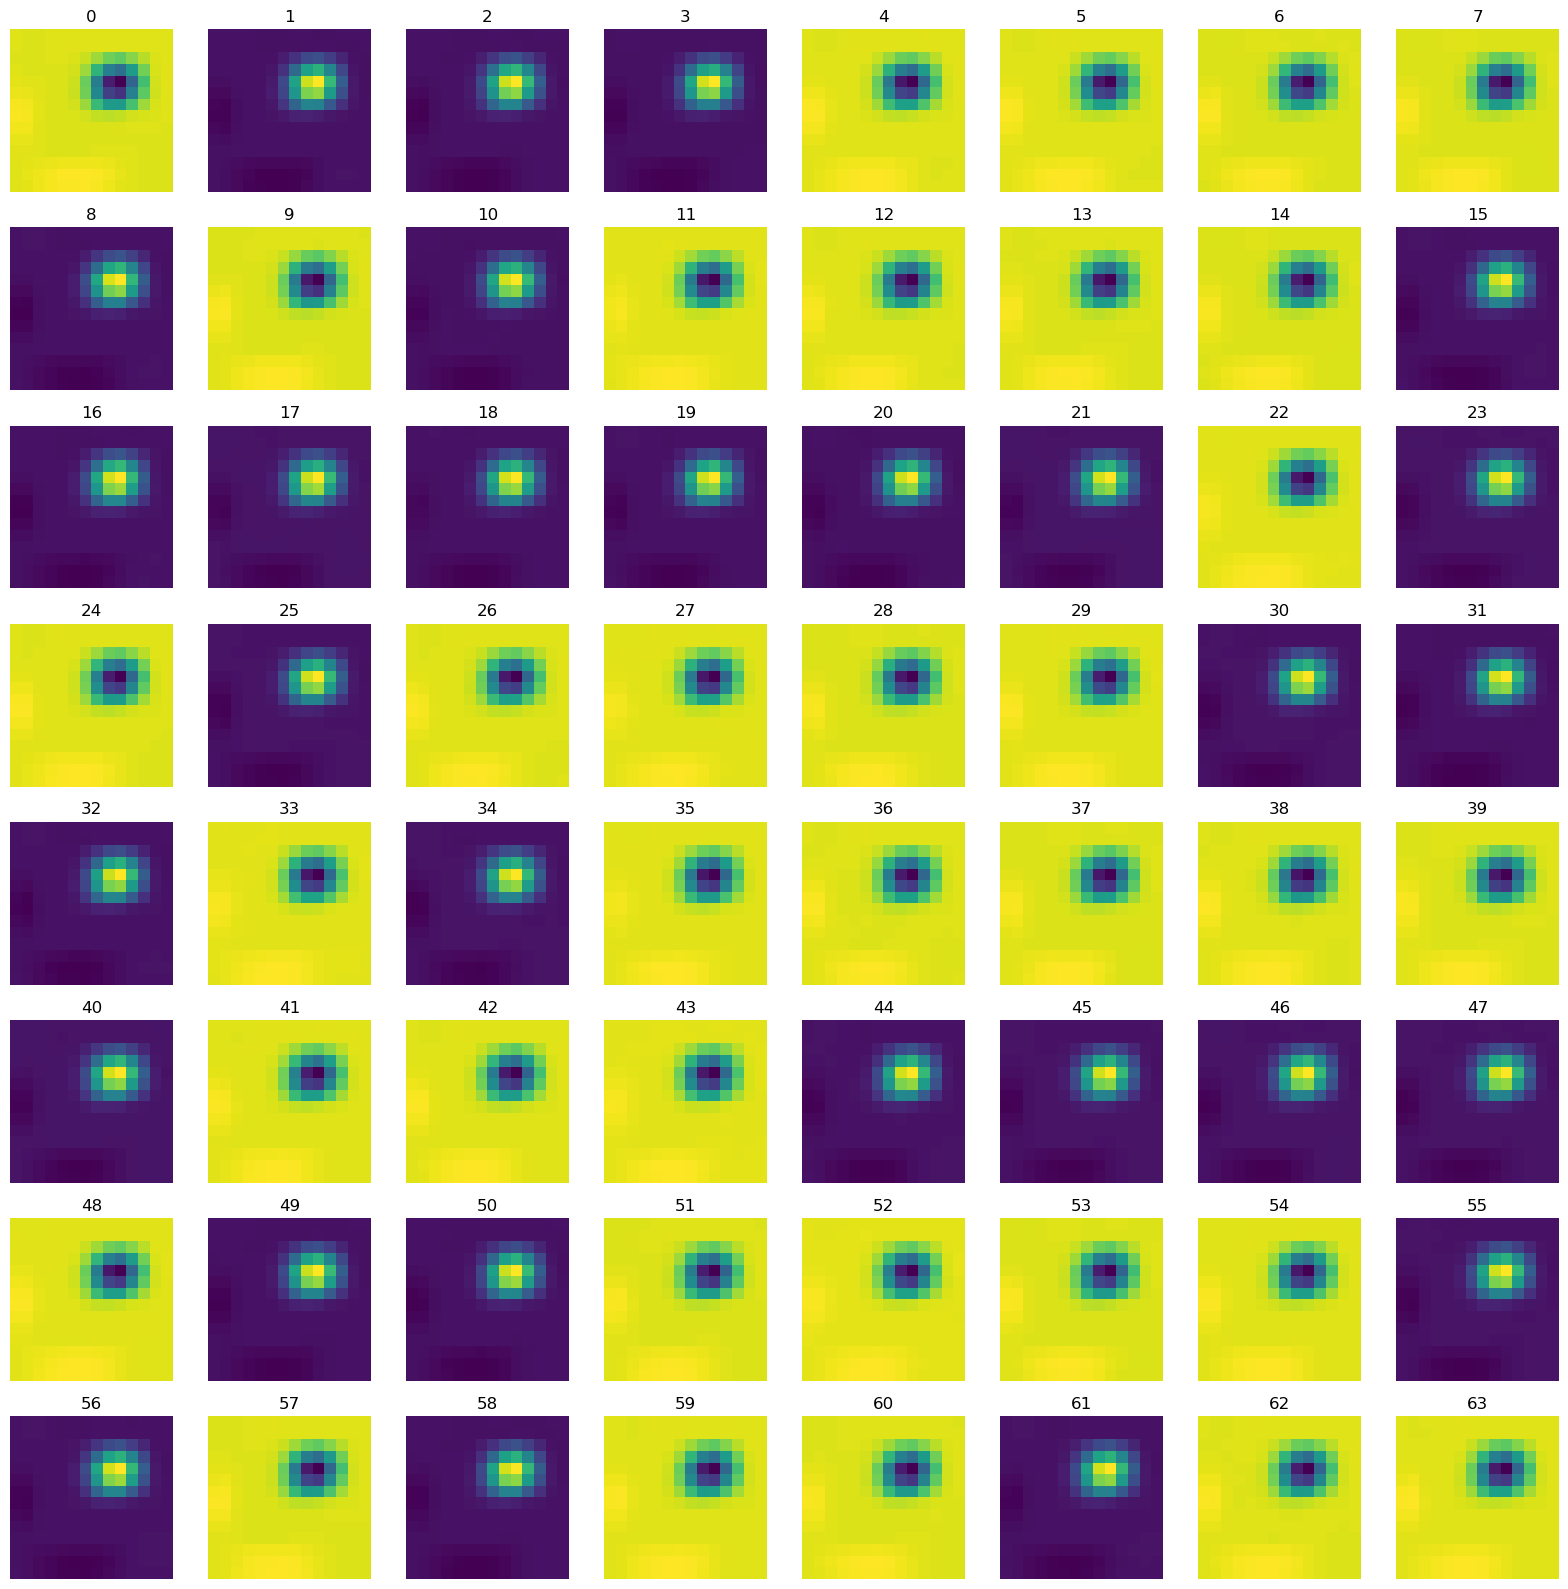

In [25]:
from fnc_blood_smears import plot_activations

plot_activations(fh.activations[0])

We can also combine activations and gradients to calculate Grad-CAM and inspect on which part of an image the CNN focuses on to predict its outputs, using the `def plot_gradcam()` function, which is added to `fns_blood_smears.py`.

```python
def plot_gradcam(image, grad_cam):
    from matplotlib import pyplot as plt
    import skimage

    grad_cam = skimage.transform.resize(grad_cam, image.shape, order=2)
    grad_cam = skimage.exposure.rescale_intensity(grad_cam, out_range=(0.25, 1))

    plt.figure(figsize=(12, 5)) 

    plt.subplot(1, 3, 1)
    plt.imshow(image, interpolation="bilinear")
    plt.title("Original image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(grad_cam.mean(axis=-1), interpolation="bilinear")
    plt.title("Grad-CAM")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(image * grad_cam)
    plt.title("Overlay")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()
```

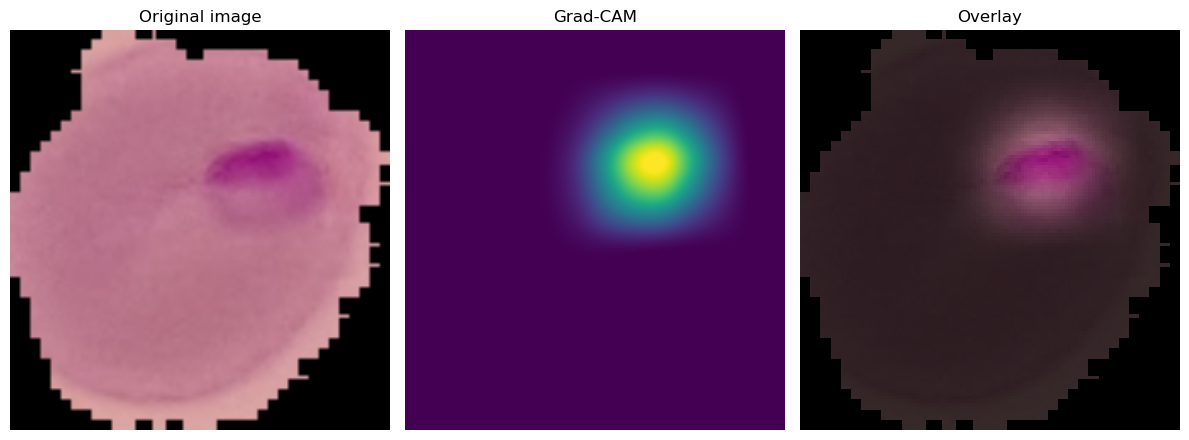

In [26]:
import matplotlib.image as mpimg

image_hr = mpimg.imread(dataset.imgs[subset.indices[test.indices[index]]][0])

from torch.nn.functional import relu
from fnc_blood_smears import plot_gradcam

pooled_gradients = bh.gradients[0].mean(dim=[1,2], keepdim=True)
grad_cam = relu((pooled_gradients * fh.activations[0]).sum(0)).detach().numpy()

plot_gradcam(image_hr, grad_cam)